 # <center>Metody Obliczeniowe w Nauce i Technice
# <center>Laboratorium 4
# <center>Symulowane wyżarzanie 
### Filip Ślazyk
### Nr albumu: 296697
### Grupa laboratoryjna: środa 17:50

# Travelling Salesman Problem

W tym zadaniu wykorzystano algorytm symulowango wyżarzania do znalezienia przybliżonego rozwiązania NP zupełnego problemu komiwojażera.

Miasta reprezentowane są przez wierzchołki (x,y) grafu, umieszczone na liście. Kolejność wierzchołków na liście definiuje ścieżkę, jaką będzie przemieszczał się komiwojażer. Kosztem (energią) danej konfiguracji układu, w tym przypadku danej ścieżki, jest jej długość.

Algorytm dąży do zminimalizowania długości ścieżki. Ponieważ TSP jest problemem nietrywialnym, symulowane wyżarzanie jako metaheurystyka może stanowić praktyczny sposób na znalezienie zadowalających rozwiązań, niekoniecznie najlepszych. Zostało to przetestowane poniżej dla różnych konfiguracji miast.


We wszystkich zadaniach wykonanych w ramach tego laboratorium, akceptacja stanu zwiększającego energię układu następowała zgodnie z poniższym schematem:

<center> $if: random[0,1] < exp(\frac{-|energy_{new} - energy_{old}|}{T})$

Dla wysokiej temperatury $exp(\frac{-|energy_{new} - energy_{old}|}{T}) \rightarrow 1$, analogicznie dla niskiej $exp(\frac{-|energy_{new} - energy_{old}|}{T}) \rightarrow 0$, czyli w wyższej temperaturze układu prawdopodobieństwo akceptacji "gorszej" konfiguracji rosło, a w niższej - malało.

Analogicznie, jeśli przy danej temperaturze różnica między energiami w kolejnych przejściach była duża, prawdopodobieństwo akceptacji "gorszej" konfiguracji było mniejsze. Dla małych kolejnych zmian energii, szansa na akceptację wyższej energii wzrastała, przez co symulowane wyżarzanie mogło  opuścić minimum lokalne z większym prawdopodobieństwem.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
import random

Do obliczania funkcji energii wykorzystano metrykę euklidesową.

In [4]:
def euclid_distance(a,b):
    return math.sqrt((b[0] - a[0])**2 + (b[1] - a[1])**2)

In [5]:
class Graph:
    path = []
    old_path = []
    
    def random_nodes_uniform(self, k, n):
        self.path = []
        for j in range(int(k)):
            x = np.random.uniform(0,2*k)
            y = np.random.uniform(0,2*k)
            self.path += [(x+ np.random.uniform(), y+np.random.uniform()) for i in range(int(n))]
            self.path.append(self.path[0])
        random.shuffle(self.path)
        
    def random_nodes_normal(self, k, n):
        self.path = []
        for j in range(int(k)):
            x = random.random()*k
            y = random.random()*k
            self.path += [(x+ np.random.normal(0.5,1)*k/n, y+np.random.normal(0.5,1)*k/n) for i in range(int(n))]
            self.path.append(self.path[0])
        random.shuffle(self.path)
    
    def show(self):
        fig = plt.subplot()
        x = list(map(lambda node: node[0], self.path))
        y = list(map(lambda node: node[1], self.path))
        fig.plot(x,y, marker=".", color="red")
    
    def energy(self):
        energy = 0
        for i in range(len(self.path)):
            energy += euclid_distance(self.path[i], self.path[(i+1)%len(self.path)])
        return energy
    
    def random_swap(self, T):
        energy = self.energy()
        a = random.randint(0, len(self.path)-1)
        b = random.randint(0, len(self.path)-1)
        self.path[a], self.path[b] = self.path[b], self.path[a]
        new_energy = self.energy()
        if new_energy > energy and random.random() > math.exp(-abs(energy-new_energy)/T):
            self.path[a], self.path[b] = self.path[b], self.path[a]
        return math.exp(-abs(energy-new_energy)/T)
            
    def neighbour_swap(self, T):
        energy = self.energy()
        a = random.randint(0, len(self.path)-2)
        self.path[a], self.path[a+1] = self.path[a+1], self.path[a]
        new_energy = self.energy()
        if new_energy > energy and random.random() > math.exp(-abs(energy-new_energy)/T):
            self.path[a], self.path[a+1] = self.path[a+1], self.path[a]
            
    def store_path(self):
        self.old_path = self.path.copy()
    
    def restore_path(self):
        self.path = self.old_path.copy()
            

Zaimplementowana funkcja realizująca symulowane wyżarzanie wykonuje wcześniej określoną liczbę iteracji. Możliwy jest wybór sposobu generowania stanu sąsiedniego ('neighbour' - consecutive swap lub 'random' - arbitrary swap). Funkcja pozwala też na wybór schematu stygnięcia (geometryczny lub liniowy).

In [6]:
t_hist = []
def simulated_annealing(G, iterations, T, k, swap_mode, temperature_mode):
    global t_hist
    t_hist = []
    x_iterations = []
    y_energy = []
    T_0 = T
    
    energy_history = []
    
    for i in range(iterations):
        if(swap_mode == 'neighbour'):
            G.neighbour_swap(T)
        else:
            G.random_swap(T)
        x_iterations.append(i)
        y_energy.append(G.energy())
        
        if temperature_mode == 'power':
            T *= k
        elif temperature_mode == 'linear':
            T = T_0*(1-i/iterations)
        t_hist.append(T)

            
    G.show()
    return x_iterations, y_energy

In [691]:
T = 0.8
k = 0.9995

In [692]:
G = Graph()

Wykonano symulacje dla 3 różnych liczb wierzchołków: 18, 45, 90. Dla każdej z tych liczb generowano układ losowany jednostajnie, normalnie, oraz w formie 9 klastrów. Wartości temperatury początkowej, jak i współczynnika $k$ wykorzystanego w geometrycznym schemacie stygnięcia dobierano eksperymentalnie, w zależności od danej konfiguracji punktów. We wszystkich poniższych przykładach wykorzystano geometryczny schemat stygnięcia oraz arbitralny wybór wierzchołków do zamiany, w celu generowania stanu sąsiedniego.

## n = 18

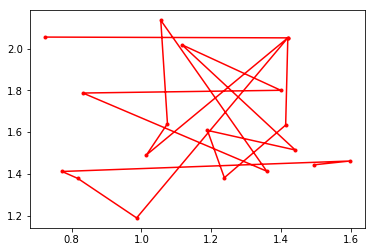

In [693]:
#uniform distributution
iterations = 30000
G.random_nodes_uniform(1, 18)
G.show()

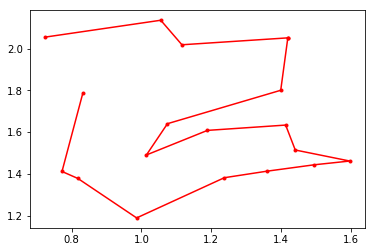

In [694]:
x, y = simulated_annealing(G, iterations, T, k, 'random', 'power')

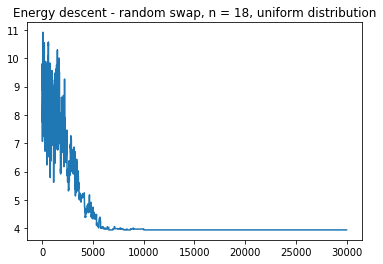

In [695]:
plt.title('Energy descent - random swap, n = 18, uniform distribution')
plt.plot(x,y)
plt.show()

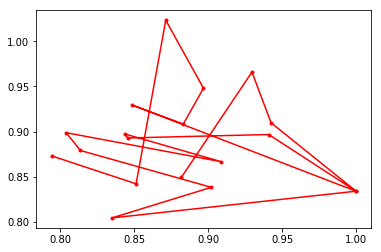

In [696]:
#normal distributution
iterations = 30000
G.random_nodes_normal(1, 18)
G.show()

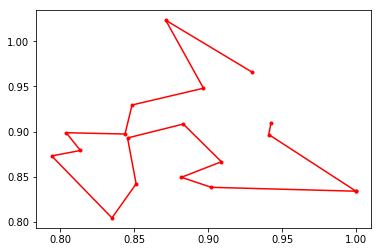

In [697]:
x, y = simulated_annealing(G, iterations, T, k, 'random', 'power')

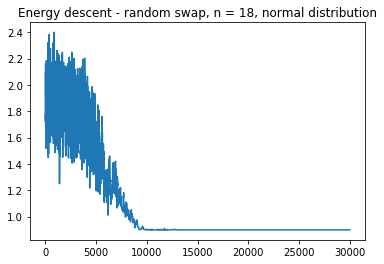

In [698]:
plt.title('Energy descent - random swap, n = 18, normal distribution')
plt.plot(x,y)
plt.show()

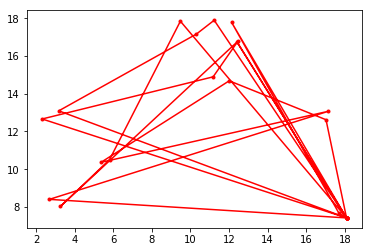

In [752]:
#9 clusters
T = 0.8
k = 0.99995
iterations = 50000
G.random_nodes_uniform(9, 2)
G.show()

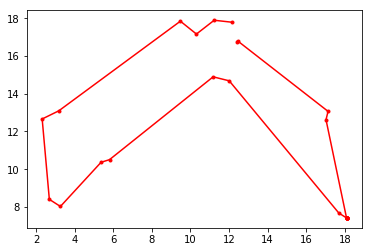

In [753]:
x, y = simulated_annealing(G, iterations, T, k, 'random', 'power')

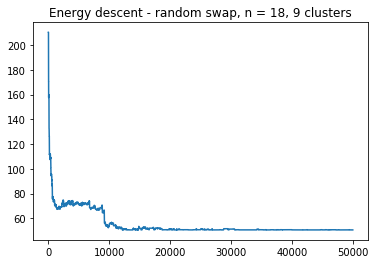

In [754]:
plt.title('Energy descent - random swap, n = 18, 9 clusters')
plt.plot(x,y)
plt.show()

Dla 18 wierzchołków, symulowanie wyżarzanie (SA) znajdowało praktycznie idealne rozwiązania.

## n = 45

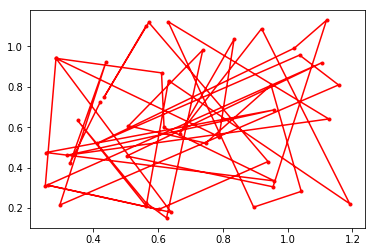

In [767]:
#uniform distributution
T = 0.8
k = 0.99995
iterations = 100000
G.random_nodes_uniform(1, 45)
G.show()

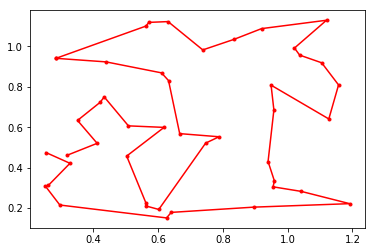

In [768]:
x, y = simulated_annealing(G, iterations, T, k, 'random', 'power')

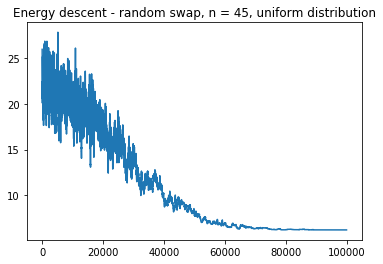

In [769]:
plt.title('Energy descent - random swap, n = 45, uniform distribution')
plt.plot(x,y)
plt.show()

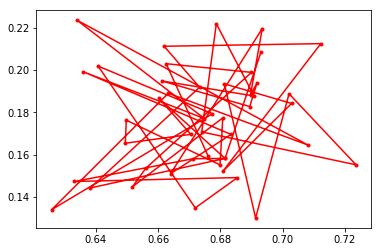

In [777]:
#normal distributution
T = 0.8
k = 0.9995
iterations = 30000
G.random_nodes_normal(1, 45)
G.show()

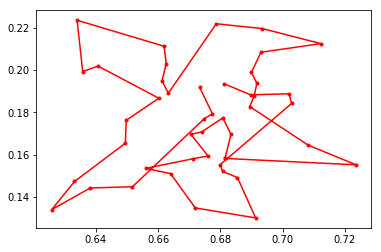

In [778]:
x, y = simulated_annealing(G, iterations, T, k, 'random', 'power')

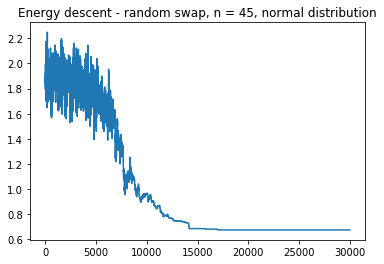

In [779]:
plt.title('Energy descent - random swap, n = 45, normal distribution')
plt.plot(x,y)
plt.show()

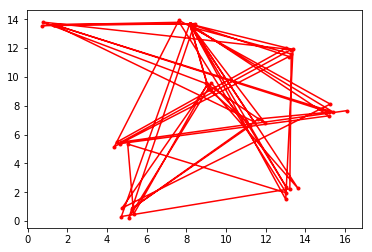

In [844]:
#9 clusters
T = 1.2
k = 0.999999
iterations = 100000
G.random_nodes_uniform(9, 5)
G.show()

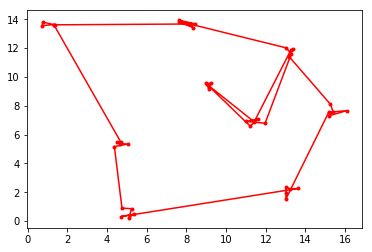

In [845]:
x, y = simulated_annealing(G, iterations, T, k, 'random', 'power')

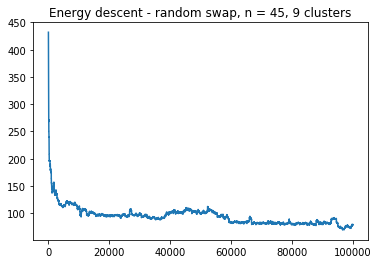

In [846]:
plt.title('Energy descent - random swap, n = 45, 9 clusters')
plt.plot(x,y)
plt.show()

Dla 45, SA nie generowało całkowicie optymalnych rozwiązań, lecz były one w akceptowalnym zakresie. W szczególności dla 9 klastrów, algorytm nie stworzył zbyt wielu nadmiarowych krawędzi między klastrami.

## n = 90

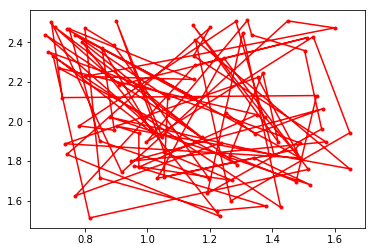

In [851]:
#uniform distributution
T = 0.8
k = 0.99995
iterations = 200000
G.random_nodes_uniform(1, 90)
G.show()

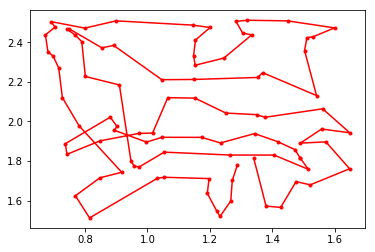

In [852]:
x, y = simulated_annealing(G, iterations, T, k, 'random', 'power')

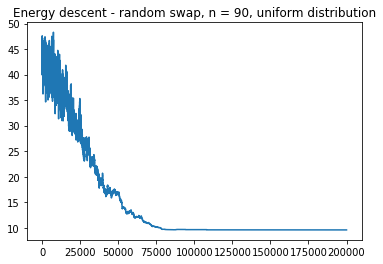

In [853]:
plt.title('Energy descent - random swap, n = 90, uniform distribution')
plt.plot(x,y)
plt.show()

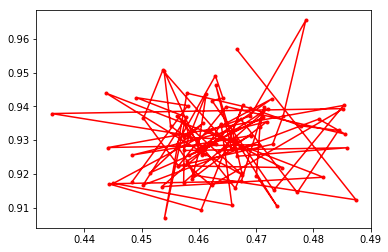

In [858]:
#normal distributution
T = 0.8
k = 0.99995
iterations = 200000
G.random_nodes_normal(1, 90)
G.show()

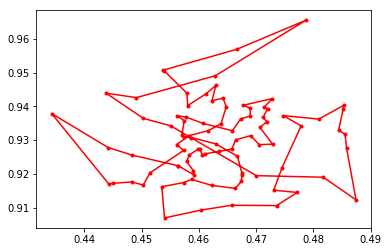

In [859]:
x, y = simulated_annealing(G, iterations, T, k, 'random', 'power')

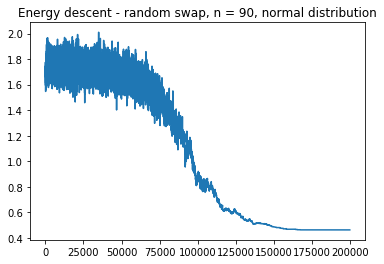

In [860]:
plt.title('Energy descent - random swap, n = 90, normal distribution')
plt.plot(x,y)
plt.show()

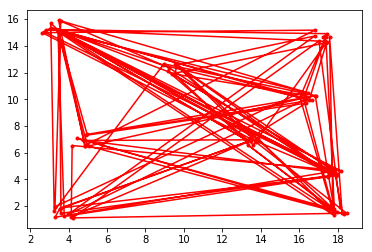

In [895]:
#9 clusters
T = 2
k = 0.999995
iterations = 150000
G.random_nodes_uniform(9, 10)
G.show()

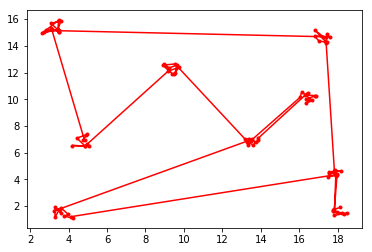

In [896]:
x, y = simulated_annealing(G, iterations, T, k, 'random', 'power')

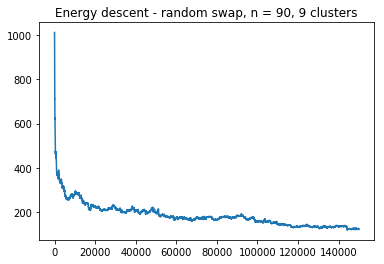

In [897]:
plt.title('Energy descent - random swap, n = 90, 9 clusters')
plt.plot(x,y)
plt.show()

Podobnie jak dla 45 wierzchołków, pobieżna analiza wizualna gotowych wyników pozwala wnioskować, iż uzyskane rozwiązania nie są optymalnymi. Jednakże wykresy energii układu wskazują, iż SA osiągnęło w każdym przypadku minimum lokalne, akceptowalne w praktycznych zastosowaniach.

## Consecutive swap vs arbitrary swap

Dokonano porównania generowania stanu sąsiedniego polegającego na zamianie sąsiednich wierzchołków na liście, jak i dwóch dowolnych z listy. Symulacja została przeprowadzona dla tej samej konfiguracji początkowej.

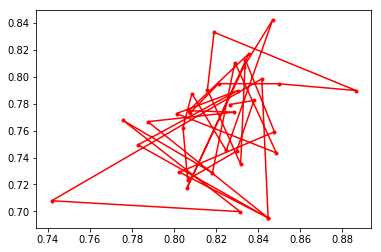

In [921]:
G1 = Graph()
G1.random_nodes_normal(1, 35)
G1.store_path()
G1.show()

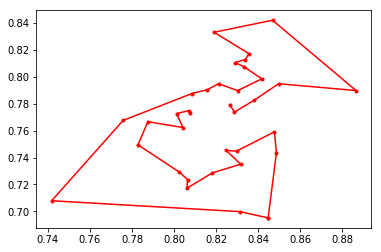

In [922]:
T = 1
k = 0.9995
iterations = 20000
x, y = simulated_annealing(G1, iterations, T, k, 'random', 'power')

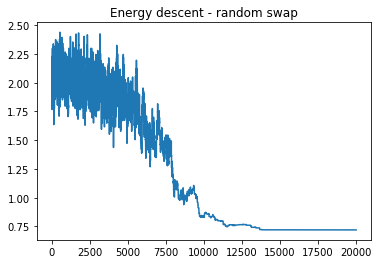

In [923]:
plt.title('Energy descent - random swap')
plt.plot(x,y)
plt.show()

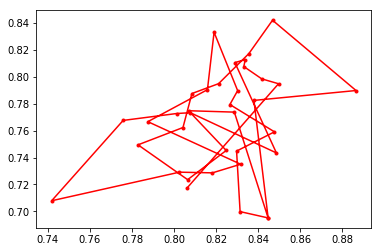

In [924]:
G1.restore_path()
T = 1
k = 0.9995
iterations = 20000
x, y = simulated_annealing(G1, iterations, T, k, 'neighbour', 'power')

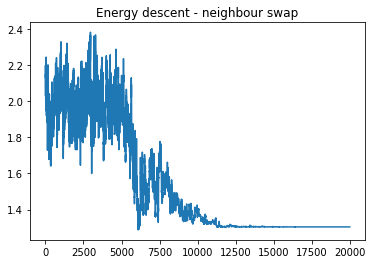

In [925]:
plt.title('Energy descent - neighbour swap')
plt.plot(x,y)
plt.show()

Przeprowadzona symulacja wskazuje, iż dla takich samych warunków początkowych, jak i tego samego schematu stygnięcia, korzystniejsze okazuje się losowe zamienianie wierzchołków. Uzyskano nim niższy końcowy koszt ścieżki.

Warto wspomnieć, iż istotnie lepsze rozwiązania może dawać połączenie obu tych sposobów zamiany, zwłaszcza w przypadku układów z klastrami. W pierwszej kolejności losowy dobór wierzchołków zminimalizuje nadmiarowe połączenia między klastrami, a następnie zamiana sąsiednich wierzchołków pozwoli na zmniejszenie energii wynikające z optymalizacji połączeń w klastrach.

## Different cooling schemes

Dla takiej samej konfiguracji początkowej ścieżki i losowej zamiany wierzchołków w stanach sąsiednich, porównano geometryczny i liniowy schemat stygnięcia.

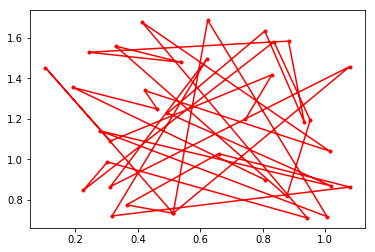

In [9]:
G1 = Graph()
G1.random_nodes_uniform(1, 35)
G1.store_path()
G1.show()

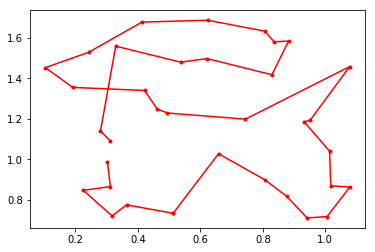

In [10]:
T = 1.2
k = 0.9995
iterations = 20000
x, y = simulated_annealing(G1, iterations, T, k, 'random', 'power')

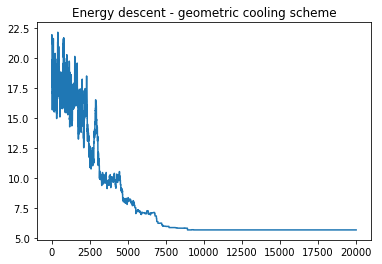

In [11]:
plt.title('Energy descent - geometric cooling scheme')
plt.plot(x,y)
plt.show()

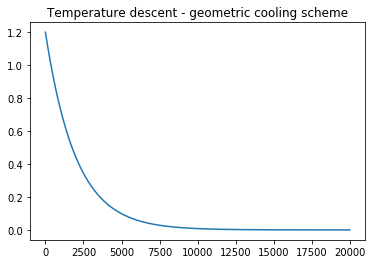

In [12]:
plt.title('Temperature descent - geometric cooling scheme')
plt.plot(x,t_hist)
plt.show()

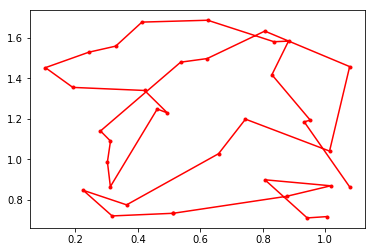

In [13]:
G1.restore_path()
T = 1
k = 0.9995
iterations = 20000
x, y = simulated_annealing(G1, iterations, T, k, 'random', 'linear')

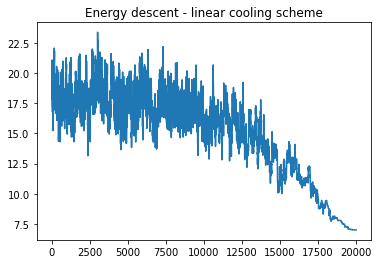

In [14]:
plt.title('Energy descent - linear cooling scheme')
plt.plot(x,y)
plt.show()

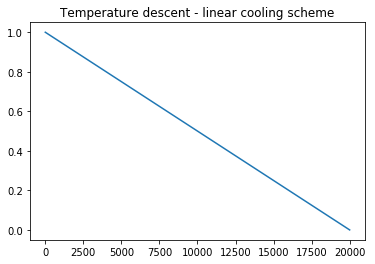

In [15]:
plt.title('Temperature descent - linear cooling scheme')
plt.plot(x,t_hist)
plt.show()

Dla określonego przykładu, tylko nieco lepszy okazał się schemat geometryczny. Jednakże jeśli porównać liczbę iteracji, schemat geometryczny zapewnia dobre rozwiązanie po dwukrotnie mniejszej liczbie iteracji względem scheamtu liniowego.

# Binary image

Zadanie opierało się na minimalizacji energii układu w formie tablicy (bitmapy) z białymi i czarnymi pikselami. Przyjęto, iż czarne piksele to cząsteczki, a białe to próżnia. Dla danej cząsteczki określona jest funkcja energii, opierająca się na liczbie innych cząsteczek w zadanym sąsiedztwie danego punktu.

Przetestowano różne funkcje energii. Na początku generowano losową tablicę o współczynniku wypełnienia $delta \in [0,1]$. Układ pierwotnie miał temperaturę $T_0$. Przy pomocy symulowanego wyżarzania dążono do minimalizacji energii całego układu (będącej sumą algebraiczną energii poszczególnych cząsteczek). Zastosowano geometryczny schemat stygnięcia. Stan sąsiedni był generowany poprzez zamianę losowych białego i czarnego piksela. Liczba iteracji, jak i dokładna wartość $T_0$ była dobierana indywidualnie dla poszczególnych tablic.

Generowanie bitmap i algorytm SA zostały zaimplementowane w pliku *binary_image_generator.cpp*, ze względu na konieczność optymalizacji przetwarzania tablic o rozmiarze 512 x 512 pikseli. Dokonano optymalizacji polegającej m.in. na lokalnym przetwarzaniu zmian energii układu, wynikających z zamiany dwóch pikseli. Pozwoliło to na obniżenie czasu generowania wynikowych bitmap do czasu rzędu 1-2 min.

Dla poniższych układów przyjęto następujące warunki brzegowe - pierwsza i ostatnia komórka danego wiersza została połączona, podobnie jak i komórki kolumn. Przez to układ może być traktowany jak powierzchnia torusa.

In [979]:
import scipy.misc
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio
mpl.rcParams['figure.dpi'] = 100


In [20]:
#function used to plot 512x512 px images
def full_frame(width=None, height=None):
    import matplotlib as mpl
    mpl.rcParams['savefig.pad_inches'] = 0
    figsize = None if width is None else (width, height)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)

## Initial state
Poniżej zaprezentowano przykładowy stan początkowy układu dla $delta = 0.5$

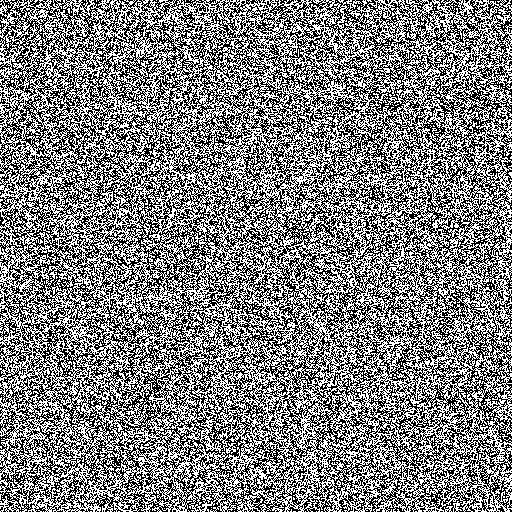

In [1056]:
full_frame(512,512)
fig = plt.gcf()
DPI = fig.get_dpi()
fig.set_size_inches(512.0/float(DPI),512.0/float(DPI))


image = np.loadtxt("./bitmaps/d=0.5_init.txt")
plt.imshow(image, Cmap = 'Greys')
plt.tight_layout()
plt.show()

## Normal vs. fast cooling - neighbourhood 1

Sprawdzono, jak zmiana tempa obniżania temperatury wpływa na efekt symulacji. Wykorzystano w tym celu następujące sąsiedztwo nr 1.

| | | |
|---|---|---|
| 0 | 1 | 0 |
| 1 | X | 1 |
| 0 | 1 | 0 |


## Normal colling pace

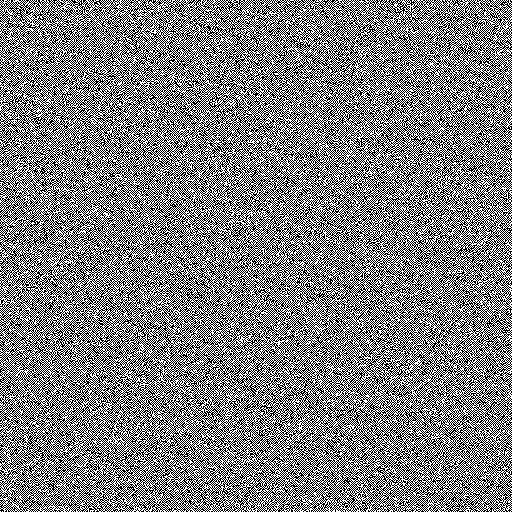

In [1060]:
full_frame(512,512)
fig = plt.gcf()
DPI = fig.get_dpi()
fig.set_size_inches(512.0/float(DPI),512.0/float(DPI))


image = np.loadtxt("./bitmaps/d=0.5_4_neigh_normal_result.txt")
plt.imshow(image, Cmap = 'Greys')
plt.tight_layout()
plt.show()

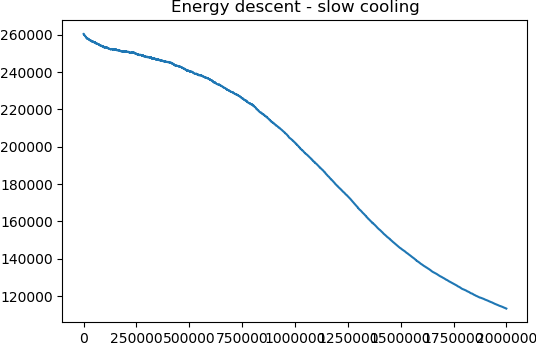

In [1066]:
energy_log = np.loadtxt("./bitmaps/d=0.5_4_neigh_normal_energy.txt")
plt.title('Energy descent - slow cooling')
plt.plot(energy_log[:,0],energy_log[:,1])
plt.show()

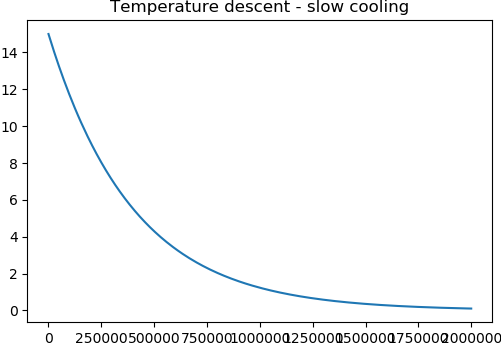

In [1067]:
temp_log = np.loadtxt("./bitmaps/d=0.5_4_neigh_normal_temp.txt")
plt.title('Temperature descent - slow cooling')
plt.plot(temp_log[:,0],temp_log[:,1])
plt.show()

## Fast cooling pace

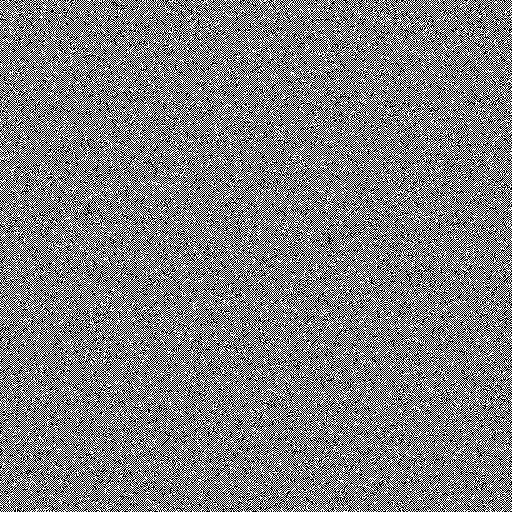

In [1063]:
full_frame(512,512)
fig = plt.gcf()
DPI = fig.get_dpi()
fig.set_size_inches(512.0/float(DPI),512.0/float(DPI))


image = np.loadtxt("./bitmaps/d=0.5_4_neigh_fast_result.txt")
plt.imshow(image, Cmap = 'Greys')
plt.tight_layout()
plt.show()

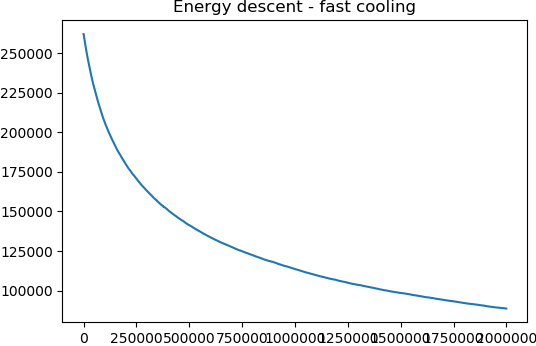

In [1069]:
energy_log = np.loadtxt("./bitmaps/d=0.5_4_neigh_fast_energy.txt")
plt.title('Energy descent - fast cooling')
plt.plot(energy_log[:,0],energy_log[:,1])
plt.show()

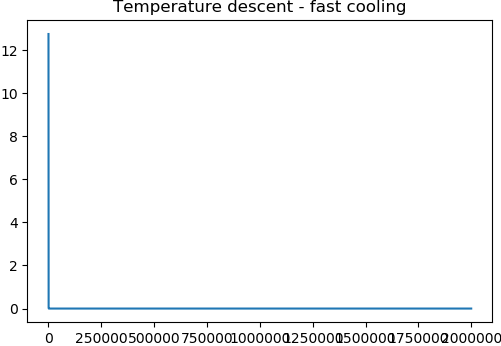

In [1068]:
temp_log = np.loadtxt("./bitmaps/d=0.5_4_neigh_fast_temp.txt")
plt.title('Temperature descent - fast cooling')
plt.plot(temp_log[:,0],temp_log[:,1])
plt.show()

W przypadku szybkiego stygnięcia, uzyskana struktura jest nieco bardziej regularna - przypomina szachownicę z "zanieczyszczeniami" w postaci nieregularnych linii. Wolniejsze stygnięcie dopuszcza stany o wyższej energii przez dłuższą część dziedziny czasu, przez co efekt cechuje się większą losowością.

## Neighbourhood 2

Kolejny testowany rodzaj sąsiedztwa zdefiniowany jest przy pomocy wartości ujemnych. Oznacza to, że bliskość dwóch pikseli powinna prowadzić do minimalizacji energii układu.

| | | |
|---|---|---|
| -1 | -1 | -1 |
| -1 | X | -1 |
| -1 | -1 | -1 |

Istotnie, uzyskano układ zawierający zgrupowania czarnych pikseli w większe grupy.

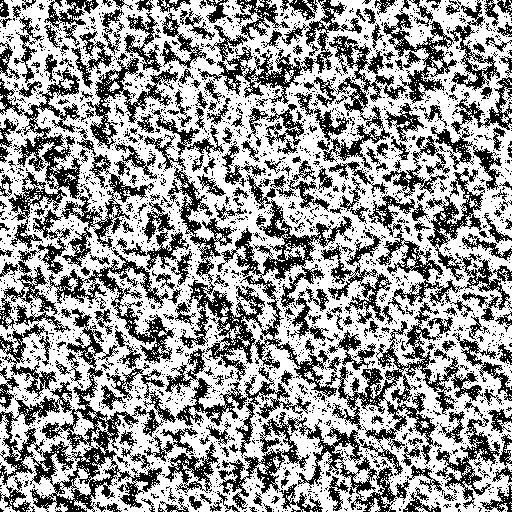

In [1074]:
full_frame(512,512)
fig = plt.gcf()
DPI = fig.get_dpi()
fig.set_size_inches(512.0/float(DPI),512.0/float(DPI))


image = np.loadtxt("./bitmaps/d=0.4_8_neigh_result.txt")
plt.imshow(image, Cmap = 'Greys')
plt.tight_layout()
plt.show()

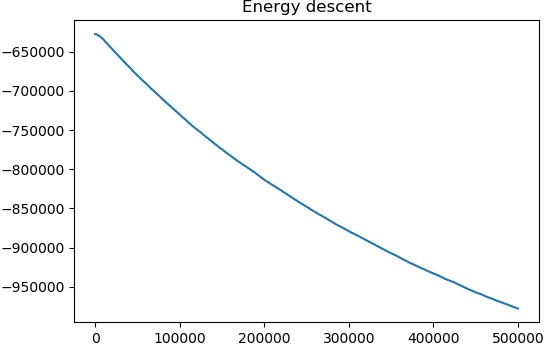

In [1075]:
energy_log = np.loadtxt("./bitmaps/d=0.4_8_neigh_energy.txt")
plt.title('Energy descent')
plt.plot(energy_log[:,0],energy_log[:,1])
plt.show()

## Neighbourhood 3

Ten rodzaj sąsiedztwa zdefiniowany jest tylko dla osi pionowej. Pozwala to spodziewać się wertykalnych struktur.

||
|----|
| -1 |
| -1 |
| -1 |
| X  |
| -1 |
| -1 |
| -1 |

Ostatecznie uzyskano układ zawierający czarne pionowe linie.

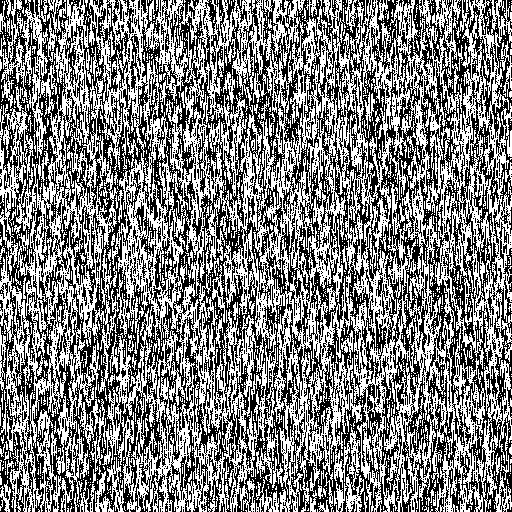

In [1077]:
full_frame(512,512)
fig = plt.gcf()
DPI = fig.get_dpi()
fig.set_size_inches(512.0/float(DPI),512.0/float(DPI))


image = np.loadtxt("./bitmaps/d=0.5_vertical_neigh_result.txt")
plt.imshow(image, Cmap = 'Greys')
plt.tight_layout()
plt.show()

## Neighbourhood 4

Kolejno zdefiniowano następujące sąsiedztwo:

| | | | | |
|----|----|----|----|----|
| -1 | -1 | -1 | -1 | 0 |
| -1 | 1  | 1  | 1  | 0 |
| -1 | 1  | X  | 1  | 0 |
| -1 | 1  | 1  | 1  | 0 |
| 0 | 0 | 0 | 0 | 0 |

Taka definicja funkcji energii doprowadziła do uformowania się struktury przypominającej labirynt.

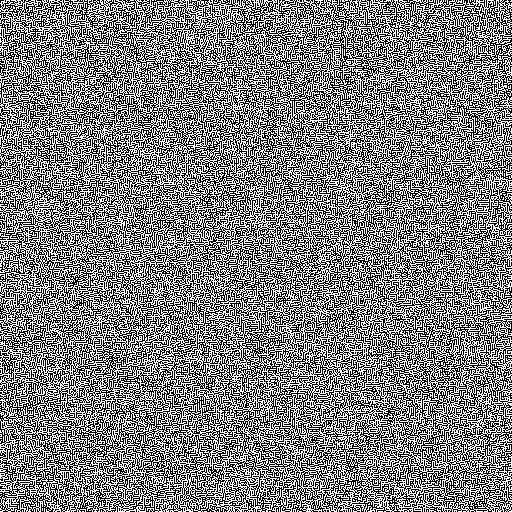

In [1081]:
full_frame(512,512)
fig = plt.gcf()
DPI = fig.get_dpi()
fig.set_size_inches(512.0/float(DPI),512.0/float(DPI))


image = np.loadtxt("./bitmaps/d=0.5_16_neigh_result.txt")
plt.imshow(image, Cmap = 'Greys')
plt.tight_layout()
plt.show()

## Neighbourhood 5

Określono także poniższe sąsiedztwo:

| | | | | |
|----|----|----|----|----|
| 1 | 1 | 1 | 1 | 0|
| 1 | -1  | -1  | -1  | 0 |
| 1 | -1  | X  | -1  | 0 |
| 1 | -1  | -1  | -1  | 0 |
| 0 | 0 | 0 | 0 | 0 |

Jednoczesna obecność wartości dodatnich i ujemnych w definicji spowodowała uformowanie się zgrupowań punktów, lecz nie tak dużych, jak w przypadku sąsiedztwa nr 2.

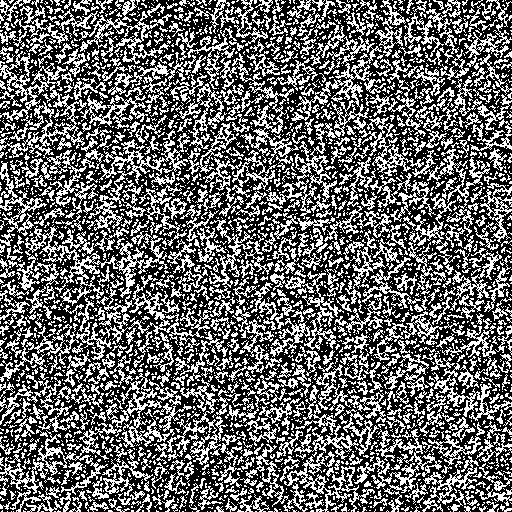

In [1083]:
full_frame(512,512)
fig = plt.gcf()
DPI = fig.get_dpi()
fig.set_size_inches(512.0/float(DPI),512.0/float(DPI))


image = np.loadtxt("./bitmaps/d=0.6_16_neg_neigh_result.txt")
plt.imshow(image, Cmap = 'Greys')
plt.tight_layout()
plt.show()

## Neighbourhood 6

Ostatnim badanym rodzajem sąsiedztwa było poniższe:

| | | | | |
|----|----|----|----|----|
| -1 | -1 | -1 | -1 | 0 |
| 1 | -1  | 1  | -1  | 0 |
| 1 | -1  | X  | -1  | 0 |
| 1 | -1  | 1  | -1  | 0 |
| 0 | 0 | 0 | 0 | 0 |

Spowodowało ono wytworzenie się nietrywialnych, wertykalnych struktur.

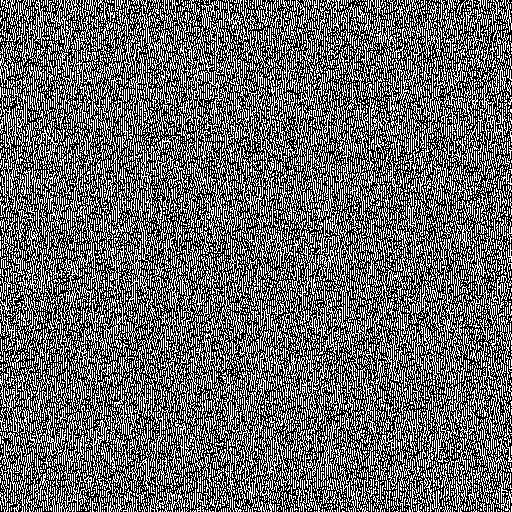

In [22]:
full_frame(512,512)
fig = plt.gcf()
DPI = fig.get_dpi()
fig.set_size_inches(512.0/float(DPI),512.0/float(DPI))


image = np.loadtxt("./bitmaps/d=0.6_16_mix_neigh_result.txt")
plt.imshow(image, Cmap = 'Greys')
plt.tight_layout()
plt.show()

## Neighbourhood 2 - different border conditions

Na sam koniec sprawdzono, jak zmiana warunków brzegowych wpłynie na końcowy stan układu. Przetestowano sąsiedztwo nr 2. Przyjęto, iż na brzegach (i poza nimi) jest próżnia złożona z białych pikseli. Spowodowało to, iż w bliskości brzegów występuje niewielkie odstępstwo średniej liczby cząsteczek względem środka planszy.

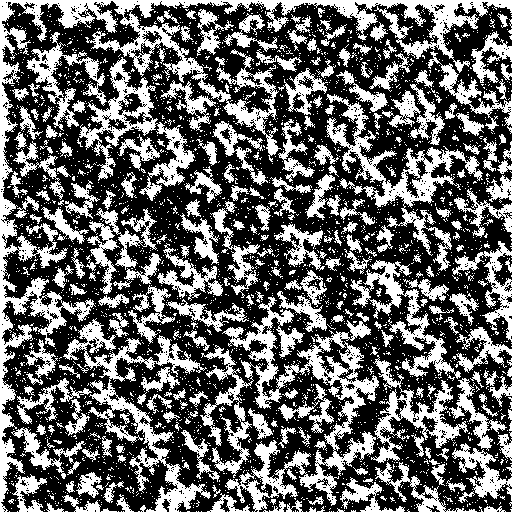

In [1086]:
full_frame(512,512)
fig = plt.gcf()
DPI = fig.get_dpi()
fig.set_size_inches(512.0/float(DPI),512.0/float(DPI))


image = np.loadtxt("./bitmaps/d=0.6_8_neigh_border_result.txt")
plt.imshow(image, Cmap = 'Greys')
plt.tight_layout()
plt.show()

# Sudoku solver

Zadanie polegało na rozwiązaniu wczytanej planszy sudoku przy pomocy algorytmu symulowanego wyżarzania. Przyjęto, iż puste pola oznaczane są w pliku cyfrą *0*. Jako funkcję kosztu przyjęto liczbę powtarzających się cyfr w poszczególnych kolumnach, wierszach i polach 3x3.

Po wczytaniu planszy z pliku, pozostałe pola wypełniano cyframi tak, aby zachować odpowiednią liczebność poszczególnych liczb na planszy (dokładnie dziewięć jedynek, dwójek, itd.). Generowanie stanu sąsiedniego polegało na zamianie dwóch losowych cyfr - tych, które nie zostały wczytane na początku, lecz wygenerowane później. Liczby wczytane na początku definiują jednoznacznie rozwiązanie, więc nie mogą być przemieszczane.

W celu optymalizacji algorytmu, dokonywano lokalnej aktualizacji funkcji kosztu. Wykorzystano geometryczny schemat stygnięcia. Wartość temperatury, współczynnika *k* jej spadku, jak i liczbę iteracji dobrano eksperymentalnie.

Ponieważ rozwiązywanie sudoku polega na poszukiwaniu minimum globalnego, dokonywano ponownych uruchomień procedury symulowanego wyżarzania po przekroczeniu określonej liczby iteracji. Nałożono górne ograniczenie 5 ponownych uruchomień. Dzięki temu udało się rozwiązać łamigłówki z 22-33 wskazówkami. Dla 20 wskazówek algorytm przekracza dopuszczalną liczbę iteracji i ponownych uruchomień, jednocześnie nie znajdując rozwiązania.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
import random

In [2]:
class Board:
    cells = np.zeros((9,9), dtype=int)
    energy = 0
    available_cells_indexes = []
    
    #convention of filling cells array:
    # 0 - empty cell
    # negative number - cell read from file that cannot be modified by Simulated Annealing algorithm
    # positive number - cell randomly generated that can be swapped by Simulated Annealing algorithm
    
    #doesn't handle invalid board definitions     
    def read_from_file(self, file_name):
        file = open(file_name, "r")
        line = file.readline()
        for i in range(9):
            for j in range(9):
                self.cells[i][j] = -int(line[i*9 + j])
        file.close()
        
    
    def show(self):
        for i in range(9):
            for j in range(9):
                if(self.cells[i][j] < 0):
                    print("\033[1;31m", -self.cells[i][j], "\033[0;0m", end = " ", sep ="")
                else: 
                    print(self.cells[i][j], end = " ")
            print("")
    
    def row_energy(self, k):
        count = [0] * 9
        for i in range(9):
            if self.cells[k-1][i] != 0:
                count[abs(self.cells[k-1][i])-1] +=1
        row_energy_sum = 0
        for i in range(9):
            if count[i] > 1:
                row_energy_sum += count[i]-1
        return row_energy_sum
        
    
    def column_energy(self, k):
        count = [0] * 9
        for i in range(9):
            if self.cells[i][k-1] != 0:
                count[abs(self.cells[i][k-1])-1] +=1
        column_energy_sum = 0
        for i in range(9):
            if count[i] > 1:
                column_energy_sum += count[i]-1
        return column_energy_sum
        
    
    def sub3x3_energy(self, r, c):
        count = [0] * 9
        for i in range(r, r + 3):
            for j in range(c, c + 3):
                if self.cells[i-1][j-1] != 0:
                    count[abs(self.cells[i-1][j-1])-1] +=1
        sub3x3_energy_sum = 0
        for i in range(9):
            if count[i] > 1:
                sub3x3_energy_sum += count[i]-1
        return sub3x3_energy_sum
        
    def update_energy(self):
        energy = 0
        for i in range(9):
            energy += self.row_energy(i)
            energy += self.column_energy(i)
    
        for i in range(1, 9, 3):
            for j in range(1, 9, 3):
                energy += self.sub3x3_energy(i,j)
                
        self.energy = energy
        return energy
    
    def swap_and_update_energy(self, r1, c1, r2, c2):
        self.energy -= self.row_energy(r1)
        self.energy -= self.row_energy(r2)
        self.energy -= self.column_energy(c1)
        self.energy -= self.column_energy(c2)
        self.energy -= self.sub3x3_energy(int((r1-1)/3)*3+1,int((c1-1)/3)*3+1)
        self.energy -= self.sub3x3_energy(int((r2-1)/3)*3+1,int((c2-1)/3)*3+1)
        self.cells[r1-1][c1-1], self.cells[r2-1][c2-1] = self.cells[r2-1][c2-1], self.cells[r1-1][c1-1]
        self.energy += self.row_energy(r1)
        self.energy += self.row_energy(r2)
        self.energy += self.column_energy(c1)
        self.energy += self.column_energy(c2)
        self.energy += self.sub3x3_energy(int((r1-1)/3)*3+1,int((c1-1)/3)*3+1)
        self.energy += self.sub3x3_energy(int((r2-1)/3)*3+1,int((c2-1)/3)*3+1)
    
    
    def fill_empty_cells(self):
        count = [0] * 9
        empty_indexes = []
        for i in range(9):
            for j in range(9):
                if self.cells[i][j] != 0:
                    count[abs(self.cells[i][j]) -1] += 1
                else:
                    empty_indexes.append((i,j))
        
        self.available_cells_indexes = empty_indexes.copy()
        for i in range(9):
            for j in range(9 - count[i]):
                random_cell = random.choice(empty_indexes)
                self.cells[random_cell] = i + 1
                empty_indexes.remove(random_cell)
                
    
    def random_swap(self, T):
        energy = self.energy
        cell1 = random.choice(self.available_cells_indexes)
        cell2 = random.choice(self.available_cells_indexes)
        
        while cell1 == cell2:
            cell2 = random.choice(self.available_cells_indexes)
        
        self.swap_and_update_energy(cell1[0]+1, cell1[1]+1, cell2[0]+1, cell2[1]+1)
        
        new_energy = self.energy
        if new_energy > energy and random.random() > math.exp(-abs(energy-new_energy)/T):
            self.swap_and_update_energy(cell1[0]+1, cell1[1]+1, cell2[0]+1, cell2[1]+1)
        return math.exp(-abs(energy-new_energy)/T)

In [4]:
def simulated_annealing(B, iterations, T, k, interval, temperature_mode):
    x_iterations = []
    y_energy = []
    
    T_0 = T
    
    max_restarts_count = 5
    restarts_count = 0
    B.update_energy()
    iterations_count = 0
    while B.energy > 0 and restarts_count < max_restarts_count:
        for i in range(iterations):
            B.random_swap(T)
            x_iterations.append(iterations_count)
            iterations_count += 1
            y_energy.append(B.energy)

            if temperature_mode == 'power':
                    T *= k
            if B.energy == 0:
                break
        restarts_count += 1
        T = T_0


    B.show()
    if(B.energy == 0):
        print('Found solution, iterations: ',iterations_count, sep='')
    else:
        print('NOT Found solution, iterations: ',iterations_count, sep='')
        
    if(restarts_count>1):
        print('Restarts count: ',restarts_count, sep='')
    return x_iterations, y_energy

0 0 0 3 4 0 0 0 2 
0 0 6 0 8 2 0 7 3 
7 0 0 1 0 0 4 5 0 
0 8 2 0 0 5 0 1 4 
0 0 0 0 9 8 3 0 0 
6 7 0 0 0 0 0 0 5 
1 4 0 7 0 0 0 0 0 
9 0 5 0 3 0 0 2 0 
0 3 0 0 0 0 8 0 6 

9 8 1 3 4 6 9 4 2 
5 7 6 2 8 2 4 7 3 
7 4 3 1 4 6 4 5 3 
7 8 2 8 8 5 6 1 4 
7 5 9 8 9 8 3 7 1 
6 7 9 2 2 2 1 1 5 
1 4 7 7 9 8 2 1 6 
9 5 5 3 3 5 5 2 9 
6 3 6 1 4 3 8 9 6 

8 5 1 3 4 7 6 9 2 
4 9 6 5 8 2 1 7 3 
7 2 3 1 6 9 4 5 8 
3 8 2 6 7 5 9 1 4 
5 1 4 2 9 8 3 6 7 
6 7 9 4 1 3 2 8 5 
1 4 8 7 2 6 5 3 9 
9 6 5 8 3 4 7 2 1 
2 3 7 9 5 1 8 4 6 
Found solution, iterations: 5981


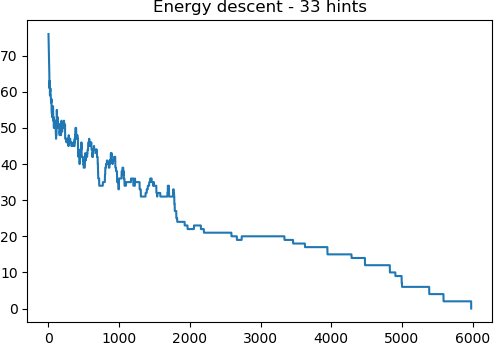

0


In [1117]:
B = Board()
B.read_from_file("./sudoku_boards/sudoku33.txt")
B.show()

B.update_energy()

print()
B.fill_empty_cells()
B.show()
print()

it = 250000
T = 1
k = 0.9995
interval = 1

x, y = simulated_annealing(B, it, T, k, interval, 'power' )
plt.title('Energy descent - 33 hints')
plt.plot(x,y)
plt.show()
print(B.energy)

0 0 0 0 4 0 0 0 2 
0 0 6 0 8 2 0 7 3 
7 0 0 1 0 0 4 5 0 
0 8 2 0 0 5 0 1 4 
0 0 0 0 9 8 3 0 0 
6 7 0 0 0 0 0 0 5 
1 4 0 7 0 0 0 0 0 
9 0 5 0 3 0 0 2 0 
0 3 0 0 0 0 8 0 6 

8 7 8 8 4 4 9 1 2 
7 6 6 1 8 2 6 7 3 
7 7 9 1 7 7 4 5 4 
4 8 2 3 5 5 5 1 4 
2 8 5 4 9 8 3 1 2 
6 7 8 2 9 4 3 9 5 
1 4 1 7 6 3 3 9 2 
9 6 5 5 3 1 9 2 9 
2 3 3 1 6 6 8 5 6 

8 5 1 3 4 7 6 9 2 
4 9 6 5 8 2 1 7 3 
7 2 3 1 6 9 4 5 8 
3 8 2 6 7 5 9 1 4 
5 1 4 2 9 8 3 6 7 
6 7 9 4 1 3 2 8 5 
1 4 8 7 2 6 5 3 9 
9 6 5 8 3 4 7 2 1 
2 3 7 9 5 1 8 4 6 
Found solution, iterations: 11460


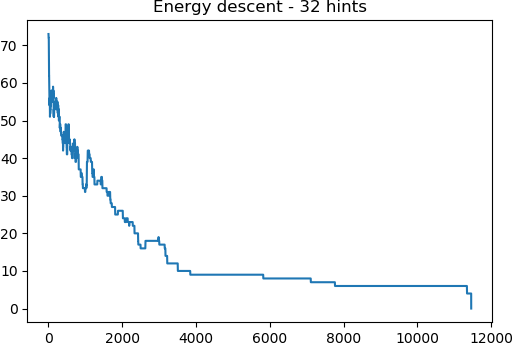

0


In [1119]:
B = Board()
B.read_from_file("./sudoku_boards/sudoku32.txt")
B.show()

B.update_energy()

print()
B.fill_empty_cells()
B.show()
print()

it = 250000
T = 1
k = 0.9995
interval = 1

x, y = simulated_annealing(B, it, T, k, interval, 'power' )
plt.title('Energy descent - 32 hints')
plt.plot(x,y)
plt.show()
print(B.energy)

0 0 0 3 4 0 0 0 2 
0 0 6 0 8 2 0 7 3 
7 0 0 1 0 0 4 5 0 
0 8 2 0 0 5 0 1 4 
0 0 0 0 9 8 3 0 0 
0 0 0 0 0 0 0 0 5 
1 4 0 7 0 0 0 0 0 
9 0 5 0 3 0 0 2 0 
0 3 0 0 0 0 8 0 6 

6 6 9 3 4 8 1 1 2 
2 4 6 5 8 2 1 7 3 
7 7 1 1 5 9 4 5 9 
4 8 2 7 3 5 9 1 4 
1 6 5 2 9 8 3 6 7 
3 6 4 5 7 8 2 9 5 
1 4 5 7 8 2 4 6 8 
9 9 5 4 3 1 7 2 3 
2 3 6 7 9 8 8 3 6 

8 5 1 3 4 7 6 9 2 
4 9 6 5 8 2 1 7 3 
7 2 3 1 6 9 4 5 8 
3 8 2 6 7 5 9 1 4 
5 1 4 2 9 8 3 6 7 
6 7 9 4 1 3 2 8 5 
1 4 8 7 2 6 5 3 9 
9 6 5 8 3 4 7 2 1 
2 3 7 9 5 1 8 4 6 
Found solution, iterations: 12330


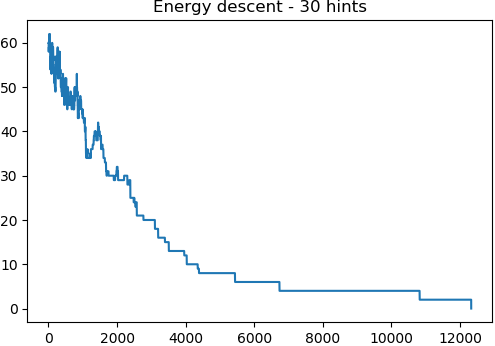

0


In [1110]:
B = Board()
B.read_from_file("./sudoku_boards/sudoku30.txt")
B.show()

B.update_energy()

print()
B.fill_empty_cells()
B.show()
print()

it = 250000
T = 1
k = 0.9995
interval = 1

x, y = simulated_annealing(B, it, T, k, interval, 'power' )
plt.title('Energy descent - 30 hints')
plt.plot(x,y)
plt.show()
print(B.energy)

0 0 0 3 4 0 0 0 2 
0 0 6 0 8 2 0 7 0 
0 0 0 1 0 0 4 5 0 
0 8 2 0 0 5 0 1 4 
0 0 0 0 9 8 3 0 0 
0 0 0 0 0 0 0 0 5 
1 4 0 7 0 0 0 0 0 
9 0 5 0 3 0 0 2 0 
0 3 0 0 0 0 8 0 6 

4 5 6 3 4 4 8 7 2 
7 2 6 7 8 2 4 7 1 
9 6 5 1 6 3 4 5 4 
1 8 2 6 9 5 1 1 4 
2 8 5 5 9 8 3 6 3 
9 3 7 2 1 5 4 6 5 
1 4 7 7 7 2 3 7 8 
9 8 5 9 3 9 2 2 1 
8 3 9 3 1 9 8 6 6 

8 5 1 3 4 7 6 9 2 
4 9 6 5 8 2 1 7 3 
7 2 3 1 6 9 4 5 8 
3 8 2 6 7 5 9 1 4 
5 1 4 2 9 8 3 6 7 
6 7 9 4 1 3 2 8 5 
1 4 8 7 2 6 5 3 9 
9 6 5 8 3 4 7 2 1 
2 3 7 9 5 1 8 4 6 
Found solution, iterations: 44917


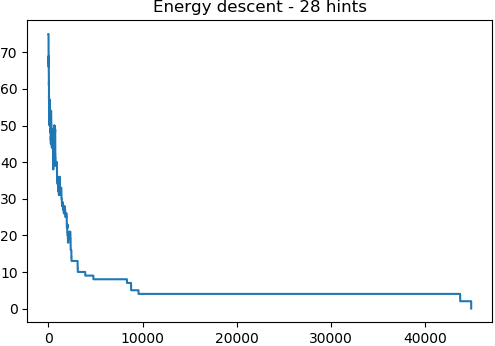

0


In [1112]:
B = Board()
B.read_from_file("./sudoku_boards/sudoku28.txt")
B.show()

B.update_energy()

print()
B.fill_empty_cells()
B.show()
print()

it = 250000
T = 1
k = 0.9995
interval = 1

x, y = simulated_annealing(B, it, T, k, interval, 'power' )
plt.title('Energy descent - 28 hints')
plt.plot(x,y)
plt.show()
print(B.energy)

0 0 0 3 4 0 0 0 2 
0 0 6 0 8 2 0 7 0 
0 0 0 1 0 0 4 5 0 
0 8 2 0 0 5 0 0 0 
0 0 0 0 9 8 3 0 0 
0 0 0 0 0 0 0 0 5 
0 0 0 7 0 0 0 0 0 
9 0 5 0 3 0 0 2 0 
0 3 0 0 0 0 8 0 6 

6 1 7 3 4 2 4 7 2 
7 3 6 8 8 2 9 7 9 
6 4 3 1 5 6 4 5 4 
8 8 2 7 1 5 6 1 5 
2 1 1 6 9 8 3 8 1 
8 9 1 6 9 4 9 1 5 
4 4 9 7 9 8 5 2 2 
9 3 5 4 3 7 2 2 5 
7 3 6 7 3 5 8 3 6 

5 9 8 3 4 7 1 6 2 
1 4 6 5 8 2 9 7 3 
7 2 3 1 6 9 4 5 8 
3 8 2 4 7 5 6 9 1 
6 5 1 2 9 8 3 4 7 
4 7 9 6 1 3 2 8 5 
8 1 4 7 2 6 5 3 9 
9 6 5 8 3 1 7 2 4 
2 3 7 9 5 4 8 1 6 
Found solution, iterations: 335079
Restarts count: 2


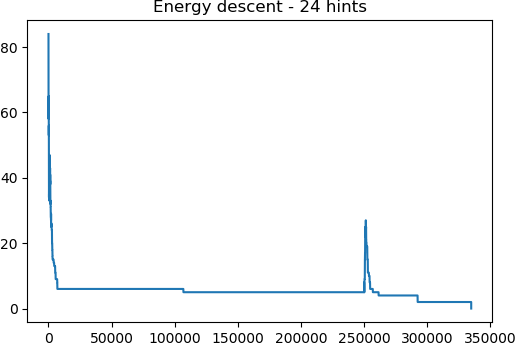

0


In [1113]:
B = Board()
B.read_from_file("./sudoku_boards/sudoku24.txt")
B.show()

B.update_energy()

print()
B.fill_empty_cells()
B.show()
print()

it = 250000
T = 1
k = 0.9995
interval = 1

x, y = simulated_annealing(B, it, T, k, interval, 'power' )
plt.title('Energy descent - 24 hints')
plt.plot(x,y)
plt.show()
print(B.energy)

0 0 0 3 4 0 0 0 2 
0 0 6 0 8 2 0 7 0 
0 0 0 1 0 0 0 5 0 
0 0 2 0 0 5 0 0 0 
0 0 0 0 9 8 3 0 0 
0 0 0 0 0 0 0 0 5 
0 0 0 7 0 0 0 0 0 
9 0 5 0 3 0 0 2 0 
0 3 0 0 0 0 8 0 6 

9 4 6 3 4 7 6 1 2 
4 6 6 8 8 2 1 7 2 
7 4 2 1 2 6 7 5 6 
9 4 2 8 7 5 9 3 3 
6 5 4 7 9 8 3 8 5 
3 2 7 4 1 2 3 4 5 
1 8 1 7 1 3 1 5 7 
9 9 5 6 3 8 9 2 1 
4 3 9 8 5 9 8 5 6 

5 7 1 3 4 9 6 8 2 
4 9 6 5 8 2 1 7 3 
8 2 3 1 6 7 9 5 4 
3 6 2 4 1 5 7 9 8 
7 5 4 2 9 8 3 6 1 
1 8 9 6 7 3 2 4 5 
6 4 8 7 2 1 5 3 9 
9 1 5 8 3 6 4 2 7 
2 3 7 9 5 4 8 1 6 
Found solution, iterations: 511537
Restarts count: 3


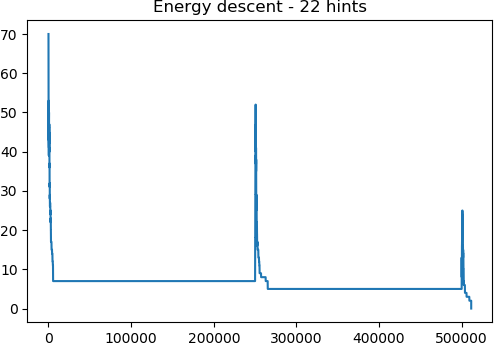

0


In [1114]:
B = Board()
B.read_from_file("./sudoku_boards/sudoku22.txt")
B.show()

B.update_energy()

print()
B.fill_empty_cells()
B.show()
print()

it = 250000
T = 1
k = 0.9995
interval = 1

x, y = simulated_annealing(B, it, T, k, interval, 'power' )
plt.title('Energy descent - 22 hints')
plt.plot(x,y)
plt.show()
print(B.energy)

0 0 0 3 4 0 0 0 2 
0 0 6 0 0 2 0 7 0 
0 0 0 1 0 0 0 5 0 
0 0 2 0 0 5 0 0 0 
0 0 0 0 9 0 3 0 0 
0 0 0 0 0 0 0 0 5 
0 0 0 7 0 0 0 0 0 
9 0 5 0 3 0 0 2 0 
0 3 0 0 0 0 8 0 6 

8 3 8 3 4 9 4 1 2 
1 5 6 2 2 2 9 7 2 
3 3 8 1 8 1 1 5 1 
4 8 2 5 1 5 7 4 7 
4 8 1 6 9 5 3 9 6 
8 4 5 7 6 2 1 5 5 
2 6 6 7 7 4 4 6 3 
9 4 5 9 3 3 7 2 6 
9 3 9 8 7 9 8 7 6 

5 7 9 3 4 8 6 1 2 
8 1 6 9 5 2 4 7 3 
3 2 4 1 7 6 9 5 8 
1 3 2 4 6 5 7 8 9 
6 5 8 2 9 7 3 4 1 
7 4 9 8 1 3 2 6 5 
2 6 1 7 8 9 5 3 4 
9 8 5 6 3 4 1 2 7 
4 3 7 5 2 1 8 9 6 
NOT Found solution, iterations: 1250000
Restarts count: 5


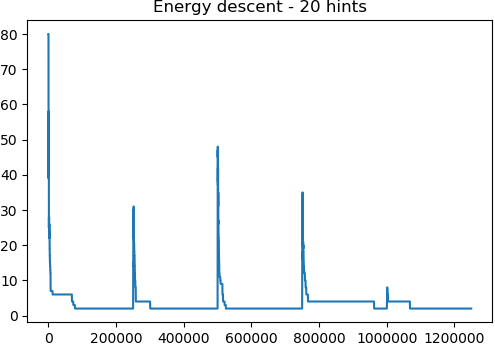

2


In [1116]:
B = Board()
B.read_from_file("./sudoku_boards/sudoku20.txt")
B.show()

B.update_energy()

print()
B.fill_empty_cells()
B.show()
print()

it = 250000
T = 1
k = 0.9995
interval = 1

x, y = simulated_annealing(B, it, T, k, interval, 'power' )
plt.title('Energy descent - 20 hints')
plt.plot(x,y)
plt.show()
print(B.energy)

## Relationship between number of hints and iterations

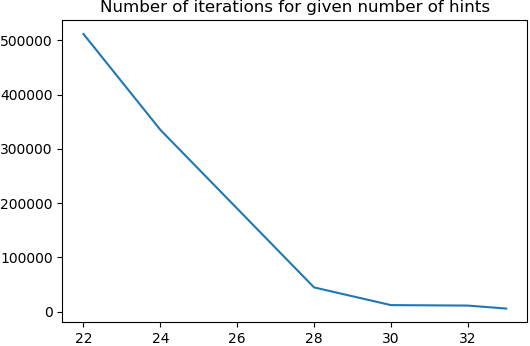

In [1120]:
x = [33, 32, 30, 28, 24, 22]
y = [5981,11460, 12330,44917,335079,511537]
plt.title('Number of iterations for given number of hints')
plt.plot(x,y)
plt.show()

Powyżej zaprezentowano liczbę iteracji potrzebnych do znalezienia rozwiązania w zależności od liczby cyfr umieszczonych na początku na planszy. W zakresie 22 - 32 wskazówki zachodzi różnica kilku rzędów wielkości. Pokazuje to, iż SA nie jest optymalnym algorytmem do znajdowania rozwiązań sudoku.

8 0 0 0 0 0 0 0 0 
0 0 3 6 0 0 0 0 0 
0 7 0 0 9 0 2 0 0 
0 5 0 0 0 7 0 0 0 
0 0 0 0 4 5 7 0 0 
0 0 0 1 0 0 0 3 0 
0 0 1 0 0 0 0 6 8 
0 0 8 5 0 0 0 1 0 
0 9 0 0 0 0 4 0 0 

8 2 6 3 1 2 7 6 9 
9 2 3 6 4 2 1 3 7 
5 7 3 7 9 1 2 8 5 
4 5 5 4 8 7 3 4 9 
8 2 6 6 4 5 7 5 1 
4 3 9 1 5 7 7 3 4 
6 3 1 5 1 8 8 6 8 
1 6 8 5 9 2 9 1 3 
6 9 9 2 8 4 4 7 2 

8 2 5 7 1 4 6 9 3 
9 1 3 6 5 2 8 7 4 
6 7 4 8 9 3 2 1 5 
1 5 9 2 3 7 4 8 6 
3 6 8 9 4 5 7 2 1 
7 4 2 1 6 8 5 3 9 
5 7 1 4 2 9 3 6 8 
4 3 8 5 7 6 9 1 2 
2 9 6 3 8 1 4 5 7 
NOT Found solution, iterations: 1250000
Restarts count: 5


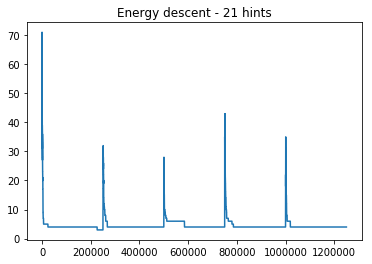

4


In [6]:
B = Board()
B.read_from_file("./sudoku_boards/sudoku_JAKUB.txt")
B.show()

B.update_energy()

print()
B.fill_empty_cells()
B.show()
print()

it = 250000
T = 1
k = 0.9995
interval = 1

x, y = simulated_annealing(B, it, T, k, interval, 'power' )
plt.title('Energy descent - 21 hints')
plt.plot(x,y)
plt.show()
print(B.energy)